In [1]:
%matplotlib inline  
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle
from fastai import *
from fastai.vision import *
import torchvision
import pretrainedmodels

In [2]:
from fastai import *
from fastai.vision import *
import pretrainedmodels

In [3]:
train_dir = 'train_set/train_set/'
val_dir = 'val_set/val_set/'

In [4]:
train_df = pd.read_csv('train_labels.csv')
train_df['path'] = train_df['img_name'].map(lambda x: os.path.join(train_dir,x))
val_df = pd.read_csv('val_labels.csv')
val_df['path'] = val_df['img_name'].map(lambda x: os.path.join(val_dir,x))

In [5]:
df = pd.concat([train_df, val_df], ignore_index=True)

In [6]:
val_idx = [i for i in range(len(train_df), len(df))]

In [7]:
sz = 256
bs = 32

In [8]:
import gc
gc.collect()

88

In [9]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.2,max_lighting=0.5,p_lighting=0.5, p_affine=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
       .split_by_idx(val_idx)
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='border') #Data augmentation
        .databunch(bs=bs,num_workers=8) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [10]:
test = ImageList.from_folder('test_set')

In [11]:
def top_3_accuracy(preds, targs):
    return top_k_accuracy(preds, targs, 3)

In [14]:
def get_ensemble(nmodels):
    ens_model = [] # Empty List of ensemble model, I will store the trained learner object here 
    learning_rate =[3e-03,3e-03,3e-03] # List of learning rate for each model 
    model_list = [models.densenet161,models.densenet169,models.densenet201] ##List of Models . You can add resnet ones in the mix
    for i in range(nmodels):
        print(f'-----Training model: {i+1}--------')
             
        learn_resnet = cnn_learner(data, model_list[i], metrics=[top_3_accuracy],
                                   model_dir="tmp/model/")

        learn_resnet.lr_find()
        learn_resnet.recorder.plot(suggestion=True)
        learn_resnet.fit_one_cycle(4,slice(learning_rate[i])) # using the learning rate for the first model 
        learn_resnet.lr_find()
        learn_resnet.recorder.plot(suggestion=True)
        learn_resnet.unfreeze()
        learn_resnet.fit_one_cycle(15 , slice(1e-5, 1e-3))

        learn_resnet.save(f'ensem_model_{i}.weights')
        ens_model.append(learn_resnet)
        print(f'-----Training of model {i+1} complete----')
    return ens_model

-----Training model: 1--------


epoch,train_loss,valid_loss,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.91E-03


epoch,train_loss,valid_loss,top_3_accuracy,time
0,3.162741,2.142953,0.687510,24:48
1,2.640297,1.758060,0.763465,24:41
2,2.364483,1.528628,0.804319,24:42
3,2.150915,1.455076,0.814074,24:41


epoch,train_loss,valid_loss,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-07


epoch,train_loss,valid_loss,top_3_accuracy,time
0,2.116130,1.429563,0.818743,32:41
1,2.134933,1.432214,0.817742,32:38
2,2.132403,1.410784,0.821577,32:40
3,2.064670,1.439407,0.815825,32:43
4,2.087279,1.373500,0.828414,32:46
5,1.934822,1.328073,0.839253,32:46
6,1.825166,1.270519,0.843755,32:44
7,1.652055,1.225282,0.855094,32:41
8,1.450635,1.171569,0.863682,32:42
9,1.319357,1.144714,0.871602,32:42


-----Training of model 1 complete----
-----Training model: 2--------


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/jupyter/.cache/torch/checkpoints/densenet169-b2777c0a.pth


epoch,train_loss,valid_loss,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 2.75E-03


epoch,train_loss,valid_loss,top_3_accuracy,time
0,3.197322,2.259517,0.664749,16:06
1,2.665034,1.826222,0.752543,16:11
2,2.451100,1.606259,0.791646,16:20
3,2.273735,1.536998,0.798399,16:20


epoch,train_loss,valid_loss,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-06


epoch,train_loss,valid_loss,top_3_accuracy,time
0,2.279634,1.507943,0.808738,21:26
1,2.206449,1.492020,0.810905,21:29
2,2.209269,1.501111,0.809405,21:29
3,2.156718,1.467667,0.813490,21:29
4,2.130921,1.429560,0.821244,21:27
5,1.965987,1.368146,0.832666,21:31
6,1.866429,1.329615,0.838252,20:53
7,1.802322,1.282813,0.844589,20:31
8,1.566234,1.233669,0.851342,20:30
9,1.535093,1.194755,0.859096,20:30


-----Training of model 2 complete----
-----Training model: 3--------


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/jupyter/.cache/torch/checkpoints/densenet201-c1103571.pth


epoch,train_loss,valid_loss,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-03


epoch,train_loss,valid_loss,top_3_accuracy,time
0,3.188538,2.224476,0.671252,20:22
1,2.715037,1.796106,0.758713,20:19
2,2.439258,1.564571,0.799066,20:20
3,2.217556,1.488236,0.810405,20:19


epoch,train_loss,valid_loss,top_3_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 3.02E-06


epoch,train_loss,valid_loss,top_3_accuracy,time
0,2.113233,1.455513,0.815324,26:06
1,2.165629,1.453228,0.817325,26:03
2,2.161473,1.474281,0.808237,26:05
3,2.130633,1.460016,0.813824,26:06
4,2.096839,1.386634,0.828914,26:05
5,1.962354,1.329671,0.836835,26:04
6,1.786218,1.284432,0.844922,26:05
7,1.657986,1.249496,0.849842,26:05
8,1.529936,1.203519,0.857262,26:06
9,1.375677,1.178795,0.862014,26:05


-----Training of model 3 complete----


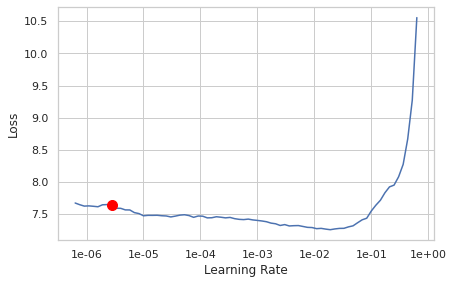

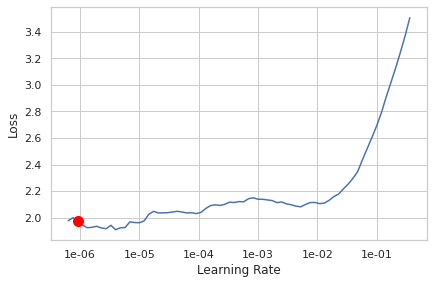

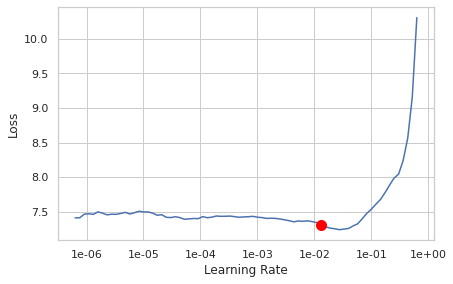

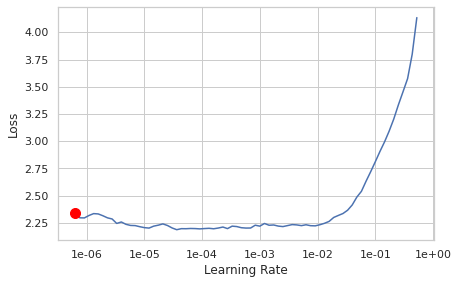

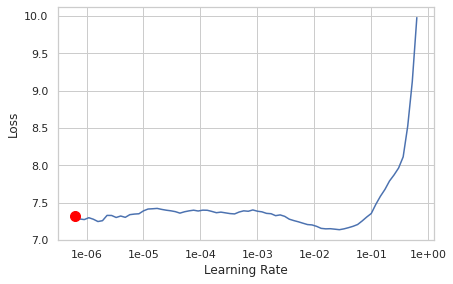

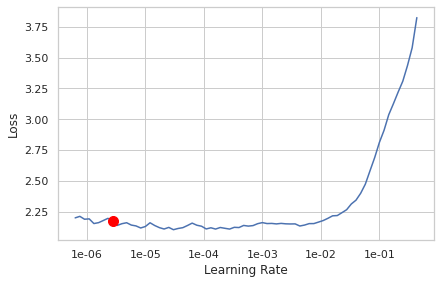

In [15]:
ens = get_ensemble(3)

In [20]:
ens_test_preds = [] ## Creating a list of predictions 
for mdl in ens:
    mdl.export('/tmp/export.pkl')
    mdl = load_learner('/tmp/', test=test)
    preds,_ = mdl.TTA(ds_type=DatasetType.Test)
    print(np.array(preds).shape)
    ens_test_preds.append(np.array(preds))

(28377, 251)


(28377, 251)


(28377, 251)


In [21]:
ens_preds = np.mean(ens_test_preds, axis =0)

In [37]:
fnames = [f.name for f in mdl.data.test_ds.items]
fnames[:4]

['test_024077.jpg', 'test_009809.jpg', 'test_020911.jpg', 'test_004197.jpg']

In [38]:
col = ['img_name']
test_df = pd.DataFrame(fnames, columns=col)
test_df['label'] = ''

In [45]:
from tqdm import tqdm_notebook as T
for i, pred in T(enumerate(ens_preds), total=len(ens_preds)):
    test_df.loc[i, 'label'] = ' '.join(str(int(i)) for i in np.argsort(pred)[::-1][:4])

In [46]:
test_df.head(15)

,img_name,label
0,test_024077.jpg,200 110 40 197
1,test_009809.jpg,48 235 109 29
2,test_020911.jpg,24 153 29 79
3,test_004197.jpg,56 138 124 165
4,test_011205.jpg,62 120 236 144
5,test_014079.jpg,81 209 207 19
6,test_003156.jpg,28 58 213 102
7,test_001750.jpg,39 119 1 53
8,test_026265.jpg,244 160 73 29
9,test_013844.jpg,92 246 71 140


In [34]:
print(ens_preds[0].shape)

(251,)


In [47]:
test_df.to_csv('ensemble_densenet.csv', index=False)

In [48]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [50]:
create_download_link(test_df, filename='ensemble_densenet_4_labels.csv')